# The effect of badly referencing an ellipse


This example demonstrates the effect of referencing your data to an incorrect
ellipse.

First we define two coordinate systems - one using the World Geodetic System
established in 1984 and the other using a spherical globe. Next we extract
data from the Natural Earth land dataset and convert the Geodetic
coordinates (referenced in WGS84) into the respective coordinate systems
that we have defined. Finally, we plot these datasets onto a map assuming
that they are both referenced to the WGS84 ellipse and compare how the
coastlines are shifted as a result of referencing the incorrect ellipse.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.io.img_tiles import MapQuestOpenAerial
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D as Line
from matplotlib.patheffects import Stroke
import numpy as np
import shapely.geometry as sgeom
from shapely.ops import transform as geom_transform

%matplotlib inline

plt.rcParams['figure.figsize'] = 15,10

def transform_fn_factory(target_crs, source_crs):
    """
    Return a function which can be used by ``shapely.op.transform``
    to transform the coordinate points of a geometry.

    The function explicitly *does not* do any interpolation or clever
    transformation of the coordinate points, so there is no guarantee
    that the resulting geometry would make any sense.

    """
    def transform_fn(x, y, z=None):
        new_coords = target_crs.transform_points(source_crs,
                                                 np.asanyarray(x),
                                                 np.asanyarray(y))
        return new_coords[:, 0], new_coords[:, 1], new_coords[:, 2]

    return transform_fn

Define the two coordinate systems with different ellipses.

In [2]:
wgs84 = ccrs.PlateCarree(globe=ccrs.Globe(datum='WGS84',
                                          ellipse='WGS84'))
sphere = ccrs.PlateCarree(globe=ccrs.Globe(datum='WGS84',
                                           ellipse='sphere'))

Define the coordinate system of the data we have from Natural Earth and
acquire the 1:10m physical coastline shapefile.

In [3]:
geodetic = ccrs.Geodetic(globe=ccrs.Globe(datum='WGS84'))
dataset = cartopy.feature.NaturalEarthFeature(category='physical',
                                              name='coastline',
                                              scale='10m')

Pick the area of interest. In our case, roughly the Solomon Islands, and
get hold of the coastlines for that area.

In [4]:
extent = (155, 163, -11.5, -6)
geoms = list(dataset.intersecting_geometries(extent))

Transform the geodetic coordinates of the coastlines into the two
projections of differing ellipses.

In [5]:

wgs84_geoms = [geom_transform(transform_fn_factory(wgs84, geodetic),
                              geom) for geom in geoms]
sphere_geoms = [geom_transform(transform_fn_factory(sphere, geodetic),
                               geom) for geom in geoms]

Plot the results

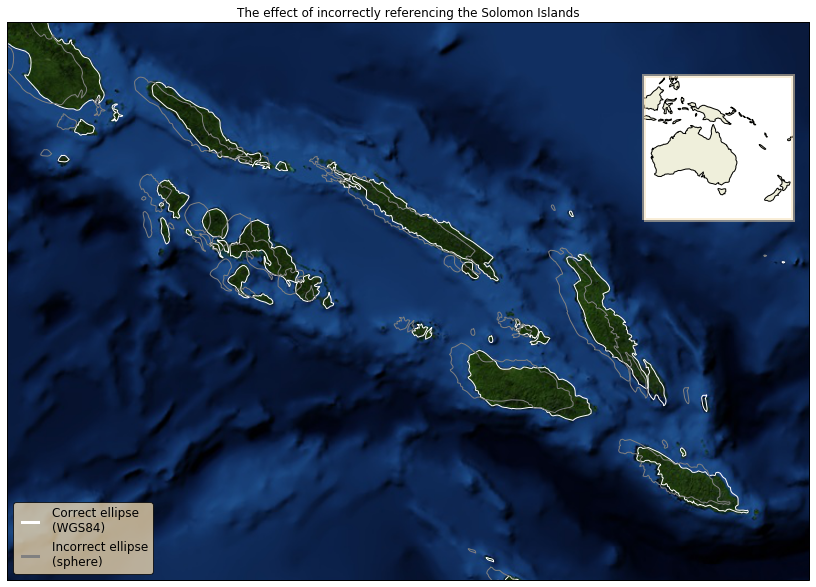

In [6]:
#Create a MapQuest map tiler instance, and use its CRS for the GeoAxes.
tiler = MapQuestOpenAerial()
ax = plt.axes(projection=tiler.crs)
ax.set_extent(extent, geodetic)
plt.title('The effect of incorrectly referencing the Solomon Islands')

# Add the MapQuest aerial imagery at zoom level 7.
ax.add_image(tiler, 7)

# Using these differently referenced geometries, assume that they are
# both referenced to WGS84.
ax.add_geometries(wgs84_geoms, wgs84, edgecolor='white', color='none')
ax.add_geometries(sphere_geoms, wgs84, edgecolor='gray', color='none')

# Create a legend for the coastlines.
legend_artists = [Line([0], [0], color=color, linewidth=3)
                  for color in ('white', 'gray')]
legend_texts = ['Correct ellipse\n(WGS84)', 'Incorrect ellipse\n(sphere)']
legend = plt.legend(legend_artists, legend_texts, fancybox=True,
                    loc='lower left', framealpha=0.75)
legend.legendPatch.set_facecolor('wheat')

# Create an inset GeoAxes showing the location of the Solomon Islands.
sub_ax = plt.axes([0.7, 0.625, 0.2, 0.2], projection=ccrs.PlateCarree())
sub_ax.set_extent([110, 180, -50, 10], geodetic)

# Make a nice border around the inset axes.
effect = Stroke(linewidth=4, foreground='wheat', alpha=0.5)
sub_ax.outline_patch.set_path_effects([effect])

# Add the land, coastlines and the extent of the Solomon Islands.
sub_ax.add_feature(cartopy.feature.LAND)
sub_ax.coastlines()
extent_box = sgeom.box(extent[0], extent[2], extent[1], extent[3])
sub_ax.add_geometries([extent_box], ccrs.PlateCarree(), color='none',
                      edgecolor='blue', linewidth=2)

plt.show()